Found 3066 images belonging to 8 classes.
Found 769 images belonging to 8 classes.
Epoch 1/30
96/96 [==============================] - 104s 989ms/step - loss: 1.7345 - accuracy: 0.3376 - val_loss: 1.5168 - val_accuracy: 0.4174 - lr: 1.0000e-04
Epoch 2/30
96/96 [==============================] - 93s 963ms/step - loss: 1.2486 - accuracy: 0.5280 - val_loss: 1.4470 - val_accuracy: 0.4317 - lr: 1.0000e-04
Epoch 3/30
96/96 [==============================] - 92s 956ms/step - loss: 1.0819 - accuracy: 0.5998 - val_loss: 1.2936 - val_accuracy: 0.4876 - lr: 1.0000e-04
Epoch 4/30
96/96 [==============================] - 93s 968ms/step - loss: 0.9718 - accuracy: 0.6295 - val_loss: 1.3967 - val_accuracy: 0.4707 - lr: 1.0000e-04
Epoch 5/30
96/96 [==============================] - 92s 956ms/step - loss: 0.9253 - accuracy: 0.6448 - val_loss: 1.4529 - val_accuracy: 0.4681 - lr: 1.0000e-04
Epoch 6/30
96/96 [==============================] - ETA: 0s - loss: 0.8703 - accuracy: 0.6699
Epoch 6: ReduceLROnPla

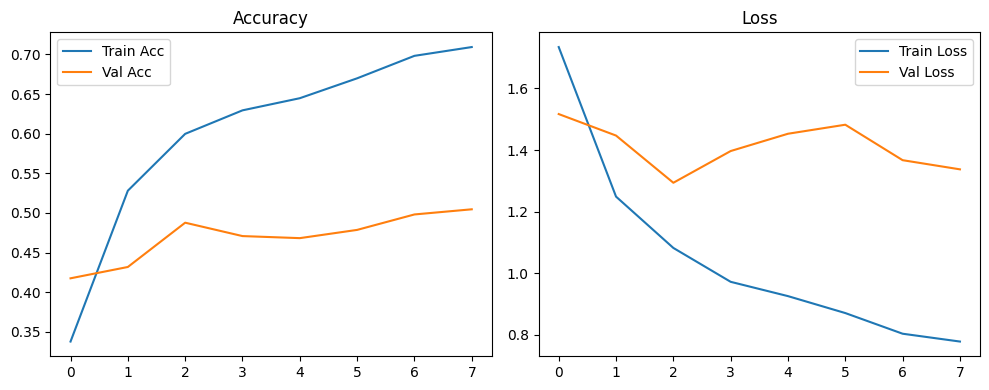

📊 Final Training Summary
📊 Best Train Accuracy: 0.7094
📊 Best Val Accuracy:   0.5046
📉 Lowest Train Loss:   0.7777
📉 Lowest Val Loss:     1.2936


In [4]:
# ========================================
# 🧠 MobileNetV2 Fine-tuned 
# ========================================
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 하이퍼파라미터
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

base_path = r"C:\Users\ghwns\HJ_git\real-time-daily-activity-recognizer\images"
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# 데이터 증강
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical'
)

# 모델 구성 (Fine-tuning + 더 깊은 Dense 구조)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-40]:  # 마지막 40개 레이어만 학습
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # 규제 강화
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# 훈련
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# 학습 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 훈련 요약
print("📊 Final Training Summary")
print(f"📊 Best Train Accuracy: {max(history.history['accuracy']):.4f}")
print(f"📊 Best Val Accuracy:   {max(history.history['val_accuracy']):.4f}")
print(f"📉 Lowest Train Loss:   {min(history.history['loss']):.4f}")
print(f"📉 Lowest Val Loss:     {min(history.history['val_loss']):.4f}")
